In [7]:
import os
from ultralytics import YOLO
from preprocessing.dedup import dedup_images_from_folder
from preprocessing.preprocess import dataset_statistics, crop_and_save_knees,show_yolo_performance


In [8]:
## to save runtime changes to False
DEDUP = True
CROP_YOLO = True
TRAIN_MODELS = True

In [9]:
DONT_USE_YOLO = False

In [10]:
my_data_dir = r"data\data_from_fastdup"
categories = ["Normal", "Osteopenia", "Osteoporosis"]



📊 **Dataset Statistics After step 0:**
  📂 Normal: 328 images
  📂 Osteopenia: 86 images
  📂 Osteoporosis: 284 images


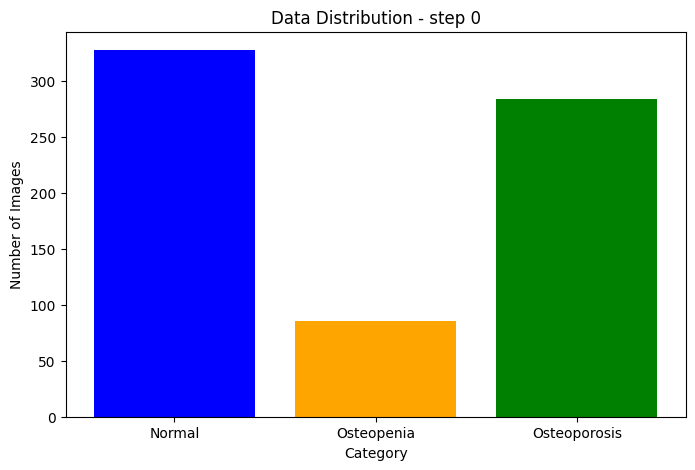

In [11]:
dataset_statistics(my_data_dir, "step 0",categories)

# run over all the data and find duplicates

2025-08-02 01:39:02,093: INFO Start: Calculating hashes...


✅ All files & folders copied to 'data\data_from_fastdup\no_dups_data'


100%|██████████| 698/698 [00:17<00:00, 39.20it/s]
2025-08-02 01:39:20,892: INFO End: Calculating hashes!
c:\Users\e0l07sq\Anaconda3\envs\osteo_gpu\lib\site-packages\imagededup\methods\hashing.py:315: SyntaxWarning: recursive parameter is irrelevant when using encodings.
  warnings.warn('recursive parameter is irrelevant when using encodings.', SyntaxWarning)
c:\Users\e0l07sq\Anaconda3\envs\osteo_gpu\lib\site-packages\imagededup\methods\hashing.py:317: RuntimeWarning: Parameter num_enc_workers has no effect since encodings are already provided
  warnings.warn('Parameter num_enc_workers has no effect since encodings are already provided', RuntimeWarning)
2025-08-02 01:39:20,892: INFO Start: Evaluating hamming distances for getting duplicates
2025-08-02 01:39:20,892: INFO Start: Retrieving duplicates using BKTree algorithm
100%|██████████| 698/698 [00:08<00:00, 82.44it/s]
2025-08-02 01:39:30,505: INFO End: Retrieving duplicates using BKTree algorithm
2025-08-02 01:39:30,511: INFO End: Eva

there are 422 unique images from 698 images
there are 276 images with 2 shows
there are 0 images with 3 shows
there are 0 images with 4 shows
there are 0 images with 5 shows
there are 0 images with 6 shows
there are 0 images with 7 shows
there are 0 images with 8 shows
there are 0 images with 9 shows
there are 0 images with 10 shows
there are 0 images with more than 10 shows
1


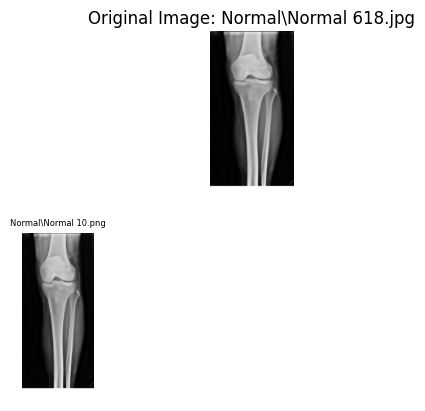

2025-08-02 01:39:30,802: INFO Start: Evaluating hamming distances for getting duplicates
2025-08-02 01:39:30,803: INFO Start: Retrieving duplicates using BKTree algorithm
100%|██████████| 698/698 [00:09<00:00, 76.49it/s]
2025-08-02 01:39:41,186: INFO End: Retrieving duplicates using BKTree algorithm
2025-08-02 01:39:41,186: INFO End: Evaluating hamming distances for getting duplicates


there are 138 to remove


In [12]:
if DEDUP:
   dedup_images_from_folder(my_data_dir,0)


📊 **Dataset Statistics After step 1:**
  📂 Normal: 254 images
  📂 Osteopenia: 86 images
  📂 Osteoporosis: 220 images


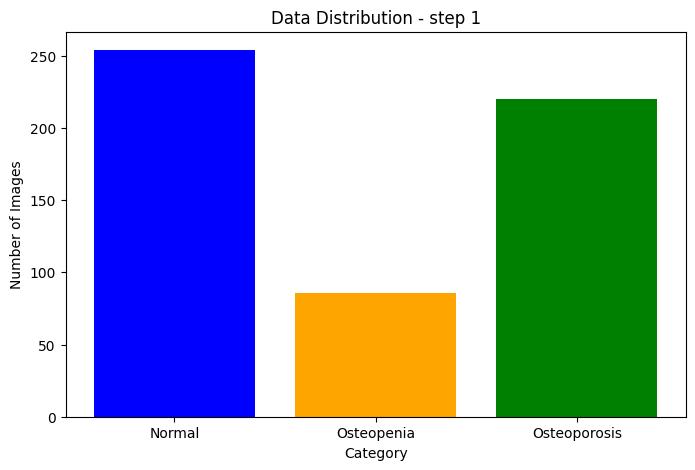

In [13]:
dedup_data_dir= os.path.join(my_data_dir,"no_dups_data")
dataset_statistics(dedup_data_dir, "step 1",categories)

# preprocess the data

WARNING  Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Loading yolo\yolo_run\weights\best.onnx for ONNX Runtime inference...
Using ONNX Runtime CUDAExecutionProvider


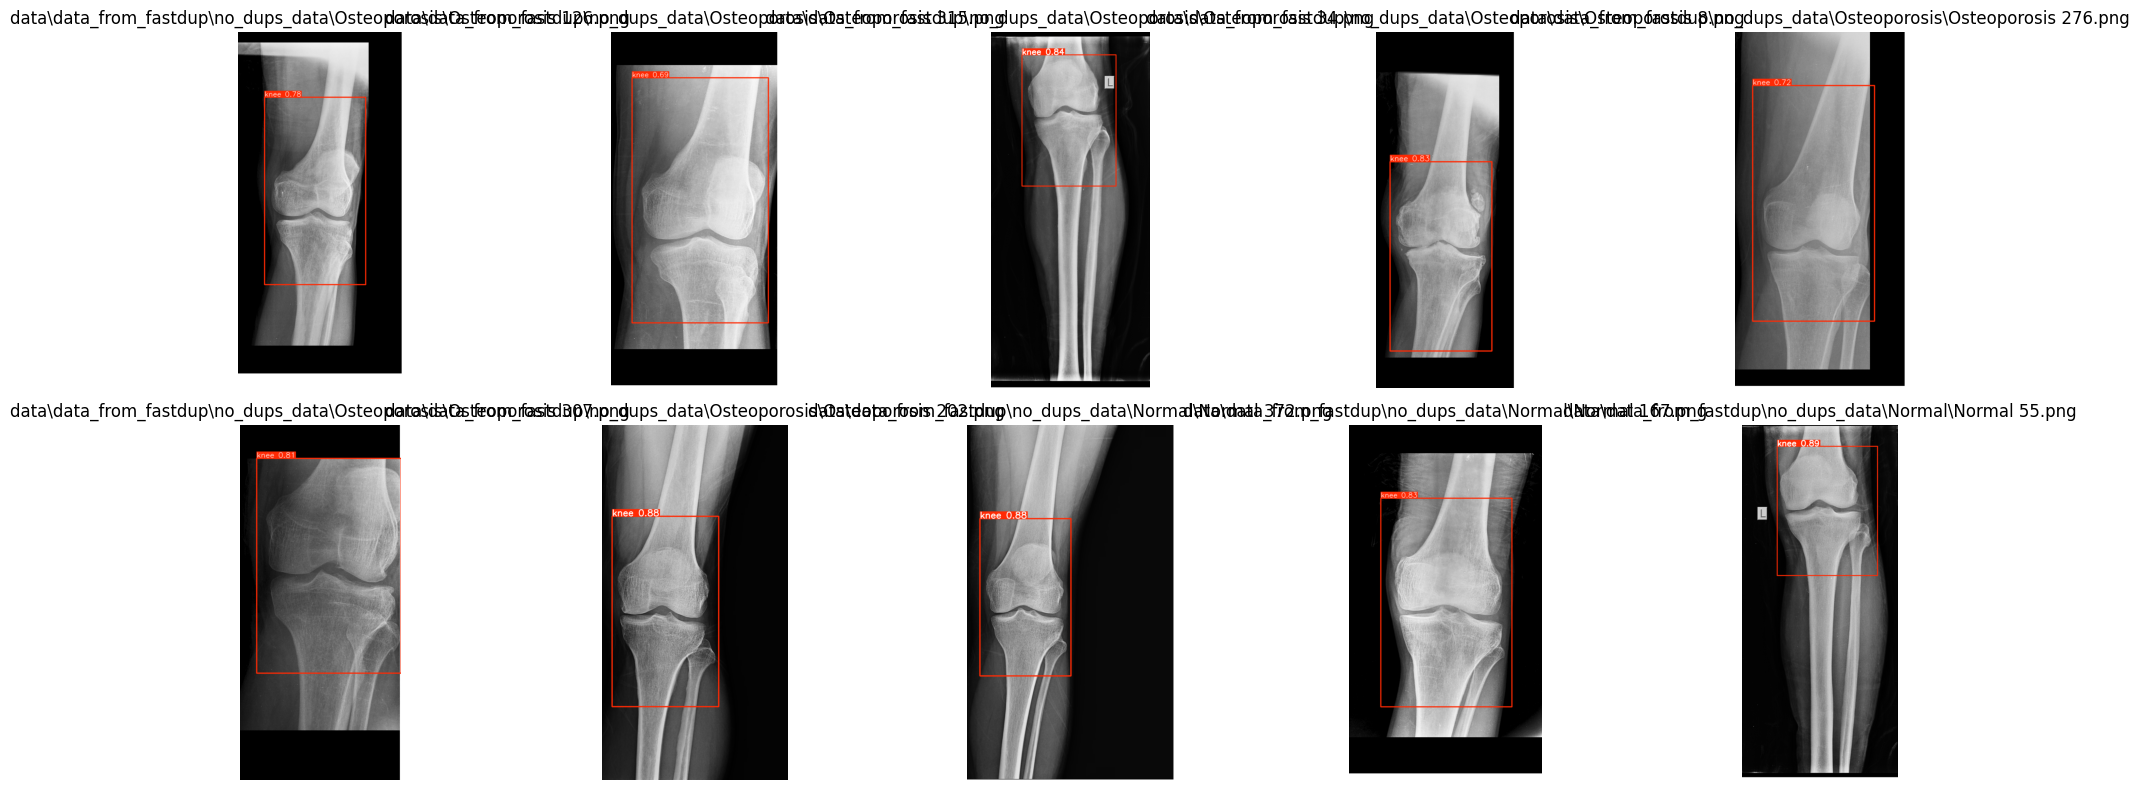

In [14]:

images_croped_by_yolo = os.path.join(dedup_data_dir, r"cropped_by_yolo")
model_path = r"yolo\yolo_run\weights\best.onnx"
model = YOLO(model_path)

if CROP_YOLO:

    show_yolo_performance(dedup_data_dir, model, categories)


In [15]:
if CROP_YOLO:
    # Ensure output directories exist
    for category in categories:
        os.makedirs(os.path.join(images_croped_by_yolo, category), exist_ok=True)
    crop_and_save_knees(dedup_data_dir, images_croped_by_yolo,model,categories)

📂 Processing Normal - 254 images


Cropping Normal: 100%|██████████| 254/254 [00:08<00:00, 30.94it/s]


📂 Processing Osteopenia - 86 images


Cropping Osteopenia: 100%|██████████| 86/86 [00:06<00:00, 13.27it/s]


📂 Processing Osteoporosis - 220 images


Cropping Osteoporosis: 100%|██████████| 220/220 [00:05<00:00, 39.42it/s]


✅ Step 2 Complete: Cropped knees saved with adaptive square logic.


# split to test and train/val

In [18]:
# Example usage
from preprocessing.split_data import split_dataset

split_dataset(r"data\data_from_fastdup\no_dups_data\no_yolo", "train_data", "test_data", test_ratio=0.2)

split_dataset(images_croped_by_yolo, "train_data", "test_data", test_ratio=0.2)


Normal: 204 train, 50 test
Osteopenia: 69 train, 17 test
Osteoporosis: 176 train, 44 test
Normal: 204 train, 50 test
Osteopenia: 69 train, 17 test
Osteoporosis: 176 train, 44 test


PermissionError: [Errno 13] Permission denied: 'data\\data_from_fastdup\\no_dups_data\\cropped_by_yolo\\test_data\\Osteopenia'

In [62]:
dedup_data_dir

'data\\OS_Collected_Data_dups\\no_dups_data\\no_dups_data'

In [64]:
split_dataset(dedup_data_dir, "train_data", "test_data", test_ratio=0.2)

# train few models 

In [47]:
train_data_path = os.path.join(images_croped_by_yolo,"train_data")
test_data_path = os.path.join(images_croped_by_yolo,"test_data")
if DONT_USE_YOLO:
    train_data_path = os.path.join(dedup_data_dir,"train_data")
    test_data_path = os.path.join(dedup_data_dir,"test_data")


In [48]:
from argparse import Namespace
from utils.logger import init_wandb


size = (512, 512) 
args1 = Namespace(LEARNING_RATE=0.00001, BATCH_SIZE=32,NUM_CLASSES=3, NUM_EPOCHS=20, USE_CLAHE=False, MODEL_NAME='ResNet50', USE_OSTEOPENIA=True, USE_TEST_DATA_DIR=True, USE_SCHEDULER=True, TRAIN_WEIGHTED_RANDOM_SAMPLER=True, NUM_WORKERS=1, DATA_DIR=train_data_path, TEST_DATA_DIR=test_data_path, USE_LABEL_SMOOTHING=True, USE_HARD_SAMPLING=False, USE_CONFIDENCE_WEIGHTED_LOSS=False, CONFIDENCE_PENALTY_WEIGHT=2.0, CONFIDENCE_THRESHOLD=0.85, LABEL_SMOOTHING_EPSILON=0.1, USE_TRANSFORM_AUGMENTATION_IN_TRAINING=True, FINE_TUNE_LR_MULTIPLIER=1.0, DROPOUT=0.5, RESNET_LAYERS_TO_TRAIN=['fc', 'layer2', 'layer3', 'layer4'])
args2 = Namespace(LEARNING_RATE=0.00001, BATCH_SIZE=32,NUM_CLASSES=3, NUM_EPOCHS=20, USE_CLAHE=False, MODEL_NAME='resnet34', USE_OSTEOPENIA=True, USE_TEST_DATA_DIR=True, USE_SCHEDULER=True, TRAIN_WEIGHTED_RANDOM_SAMPLER=True, NUM_WORKERS=1, DATA_DIR=train_data_path, TEST_DATA_DIR=test_data_path, USE_LABEL_SMOOTHING=True, USE_HARD_SAMPLING=False, USE_CONFIDENCE_WEIGHTED_LOSS=False, CONFIDENCE_PENALTY_WEIGHT=2.0, CONFIDENCE_THRESHOLD=0.85, LABEL_SMOOTHING_EPSILON=0.1, USE_TRANSFORM_AUGMENTATION_IN_TRAINING=True, FINE_TUNE_LR_MULTIPLIER=1.0, DROPOUT=0.5, RESNET_LAYERS_TO_TRAIN=['fc', 'layer2', 'layer3', 'layer4'])
args3 = Namespace(LEARNING_RATE=0.00001, BATCH_SIZE=32,NUM_CLASSES=3, NUM_EPOCHS=20, USE_CLAHE=False, MODEL_NAME='densenet121', USE_OSTEOPENIA=True, USE_TEST_DATA_DIR=True, USE_SCHEDULER=True, TRAIN_WEIGHTED_RANDOM_SAMPLER=True, NUM_WORKERS=1, DATA_DIR=train_data_path, TEST_DATA_DIR=test_data_path, USE_LABEL_SMOOTHING=True, USE_HARD_SAMPLING=False, USE_CONFIDENCE_WEIGHTED_LOSS=False, CONFIDENCE_PENALTY_WEIGHT=2.0, CONFIDENCE_THRESHOLD=0.85, LABEL_SMOOTHING_EPSILON=0.1, USE_TRANSFORM_AUGMENTATION_IN_TRAINING=True, FINE_TUNE_LR_MULTIPLIER=1.0, DROPOUT=0.5, RESNET_LAYERS_TO_TRAIN=['fc', 'layer2', 'layer3', 'layer4'])


In [ ]:

from train.train import run_training


if TRAIN_MODELS:
    run_training(args1)
    run_training(args2)
    run_training(args3)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Wandb configuration:
DATA_DIR: data\OS_Collected_Data_dups\cropped_by_yolo\train_data
TEST_DATA_DIR: data\OS_Collected_Data_dups\cropped_by_yolo\test_data
DUPLICATE_THRESHOLD: 0.99
YOLO_WEIGHTS_PATH: c:\Users\e0l07sq\Desktop\rnd\osteoporosis_project\pretrained\yolo_weights.pt
DEVICE: cuda
BATCH_SIZE: 32
NUM_EPOCHS: 20
LEARNING_RATE: 1e-05
ALEX_FREEZE_FEATURES: True
USE_TRANSFORM_AUGMENTATION_IN_TRAINING: True
USE_CLAHE: False
MODEL_NAME: ResNet50
USE_OSTEOPENIA: True
SKIP_DUP_DATA: False
TRAIN_WEIGHTED_RANDOM_SAMPLER: True
NUM_WORKERS: 1
USE_TEST_DATA_DIR: True
USE_SCHEDULER: True
USE_LABEL_SMOOTHING: True
USE_CONFIDENCE_WEIGHTED_LOSS: False
USE_HARD_SAMPLING: False
CONFIDENCE_THRESHOLD: 0.85
CONFIDENCE_PENALTY_WEIGHT: 2.0
LABEL_SMOOTHING_EPSILON: 0.1
RESNET_LAYERS_TO_TRAIN: ['fc', 'layer2', 'layer3', 'layer4']
DROPOUT: 0.5
USE_METABOLIC_FOR_TEST: False
USE_K_FOLD: False
K_FOLDS: 5
NUM_CLASSES: 3
FINE_TUNE_LR_MULTIPLIER: 1.0
Run name: lr_1e-05_bs_32_yuhz1g
Training ResNet50 model...


c:\Users\e0l07sq\Anaconda3\envs\osteo_gpu\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 7.10 GiB is allocated by PyTorch, and 103.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# show gradcam

# ensemble model

In [1]:
from train.train import get_dataloaders


(
    train_loader,
    val_loader,
    test_loader,
    test_dataset,
    train_dataset,
    val_dataset,
    train_transformations,
    eval_transform,
) = get_dataloaders()

c:\Users\e0l07sq\Anaconda3\envs\osteo_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Error: You must call wandb.init() before wandb.config.MODEL_NAME

In [ ]:

from ensemble.ensemble import ensemble_test_predictions, evaluate_predictions, load_models_from_folder,ensemble_models_from_path

num_classes = 3  # Or whatever is relevant

# Load models
folder_path = r"saved_models/ensembel_models"
class_names = ["normal", "osteopenia", "osteoporosis"]
auc, f1, acc, cm= ensemble_models_from_path(folder_path,class_names,test_dataset)


# analysis of the results

# 